<a href="https://colab.research.google.com/github/jjhhyyg/pytorch_tutorial/blob/main/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Workflow

In [50]:
what_were_covering = {1: "data (prepare and load)",
                      2: "build model",
                      3: "fitting the model to data (training)",
                      4: "making predictions and evaluating a model (inference)",
                      5: "saving and loading a model",
                      6: "putting it all together"}

what_were_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluating a model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

[torch.nn](https://pytorch.org/docs/stable/nn.html)

In [51]:
import torch
from torch import nn  # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.1.0'

## 1. Data (preparing and loading)

1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical representation.

In [52]:
# Create known parameters

weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [53]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets (one of the most important concepts in machine learning in general)

In [54]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

Visualize the data

In [55]:
def plot_predictions(train_data, train_labels, test_data, test_labels, predictions=None):
    plt.figure(figsize=(10, 7))
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")
    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
    plt.legend(prop={"size": 14})

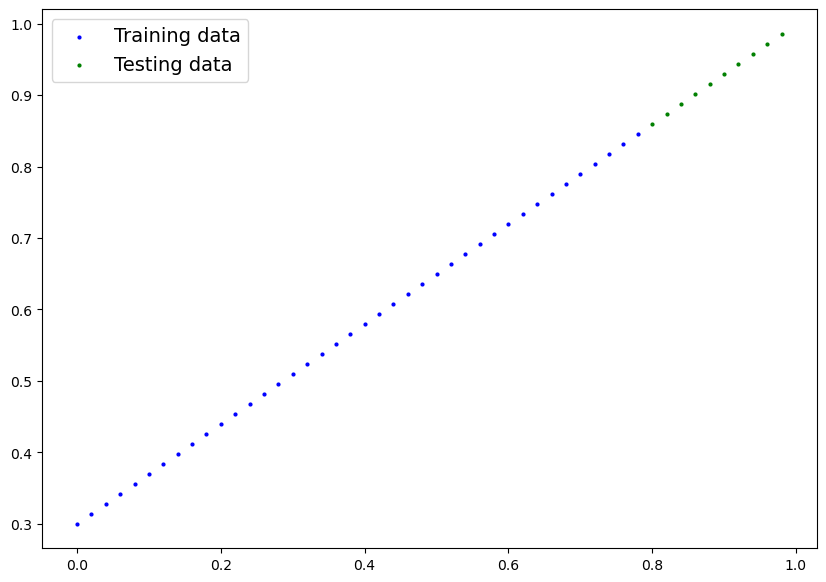

In [56]:
plot_predictions(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test)

## 2. Build model

What our model does:
- Start with random values (weight & bias)
- Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight & bias values we used to create the data)

How does it do so?
1. Gradient descent
2. Backpropagation

In [57]:
# Create linear regression model class

class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

    # Forward method to define the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

### PyTorch model building essentials

![](https://hosealle-markdown-image.oss-cn-beijing.aliyuncs.com/202310261328526.png)

 ### Checking the contents of our PyTorch model
 
Now we've created a model, let's see what's inside...

In [80]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [72]:
# List named parameters
dict(model_0.state_dict())

{'weights': tensor([0.3367]), 'bias': tensor([0.1288])}

### Making prediction using `torch.inference_mode()`

When using inference_mode, no gradient update, no backpropagation and no parameters update. It's a alternative to `torch.no_grad()`

In [60]:
# Make predictions with model
# with torch.no_grad():
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [61]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

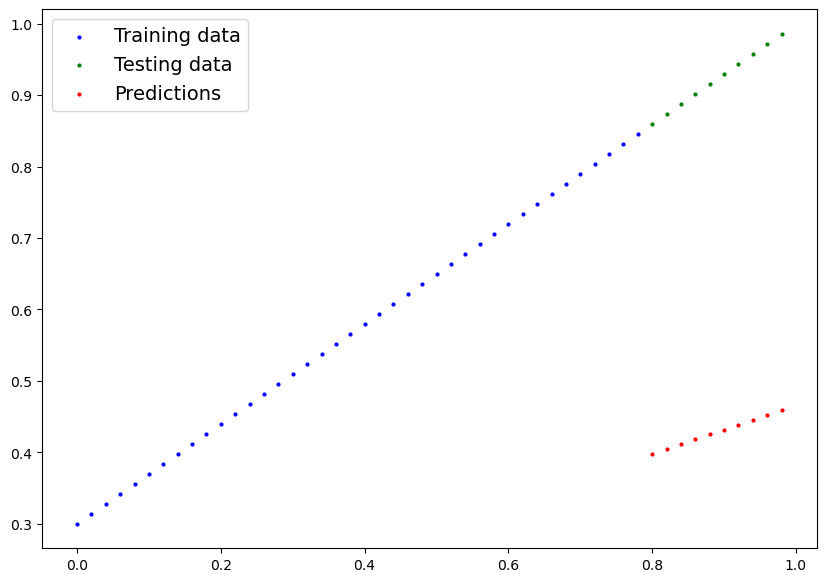

In [62]:
plot_predictions(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=y_preds)

## 3. Train model

In [63]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [64]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [65]:
import torch.nn.functional as f
import torch

f.l1_loss(torch.tensor(1.), torch.tensor(0.))

tensor(1.)

In [81]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(model_0.parameters(), lr=1e-2)

### Building a training loop (and a testing loop) in PyTorch

A couple of things we need in a training loop:

1. Loop through the data
2. Forward pass (this involves data moving through our model's `forward()` functions) to make predictions on data - also called forward propagation
3. Calculate the loss (compare forward pass predictions to ground truth labels)
4. Optimizer zero grad
5. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
6. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

In [82]:
torch.manual_seed(42)

# An epoch is one loop through the data
epochs = 200

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

### Training

# 0. Loop through the data
for epoch in range(epochs):
    # Set the model to training mode
    model_0.train()  # train mode in PyTorch sets all parameters that require gradients to require gradients

    # 1. Forward pass
    y_pred = model_0(X_train)

    # 2. Calculate the loss (input first, target next)
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Perform backpropagation on the loss with respect to the parameters of the model
    loss.backward()

    # 5. Step the optimizer (perform gradient descent)
    optimizer.step()

    model_0.eval()  # turns off gradient tracking

    # Remember that you must call model.eval() to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.
    
    ### Testing
    with torch.inference_mode():
        test_pred = model_0(X_test)
        test_loss = loss_fn(test_pred, y_test)
    
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss.item())
        test_loss_values.append(test_loss.item())
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
        print(model_0.state_dict())
    # Print out model state_dict()
    

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

In [69]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

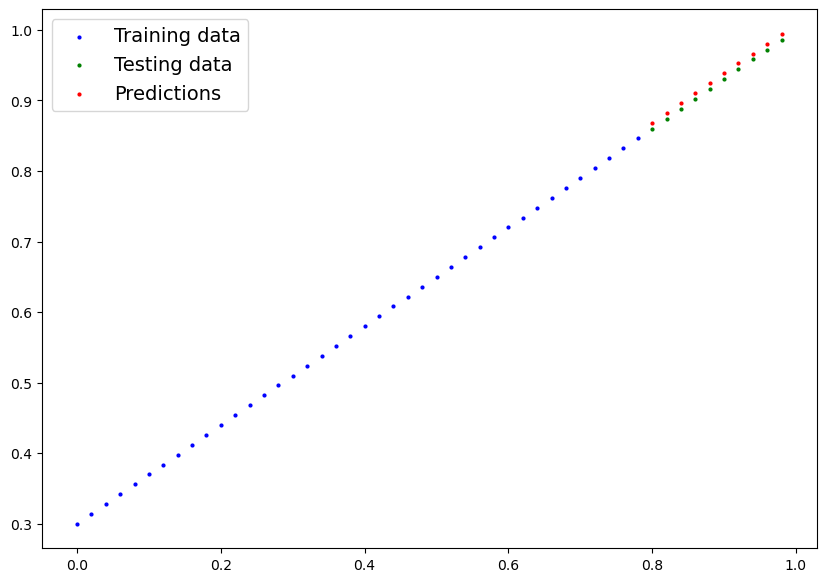

In [83]:
with torch.inference_mode():
    y_preds = model_0(X_test)
    
plot_predictions(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=y_preds)

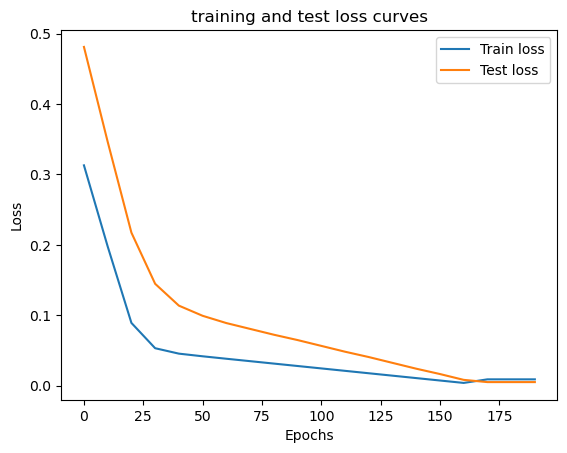

In [86]:
# Plot the loss curves

plt.plot(epoch_count, loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

## 4. Saving a model in PyTorch 

Three main methods:

1. `torch.save()` - save a PyTorch object in Python's pickle format
2. `torch.load()` - load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - load a model's saved state dictionary

In [87]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [88]:
optimizer.state_dict()

{'state': {0: {'momentum_buffer': None}, 1: {'momentum_buffer': None}},
 'param_groups': [{'lr': 0.01,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False,
   'params': [0, 1]}]}